In [1]:
# general python modules
import sys, os, pprint, pandas
import numpy as np
import matplotlib.pylab as plt
from scipy import stats

sys.path.append('../physion/src')
from physion.analysis.read_NWB import Data, scan_folder_for_NWBfiles
from physion.analysis.process_NWB import EpisodeData
sys.path.append('../')
import plot_tools as pt

from analysis import compute_tuning_response_per_cells, shift_orientation_according_to_pref

root_folder = os.path.join(os.path.expanduser('~'), 'CURATED', 'SST-ffGratingStim-2P')

## Build the dataset from the NWB files

In [2]:
DATASET = {\
    'WT':scan_folder_for_NWBfiles(os.path.join(root_folder, 'Wild-Type')),
    'KO':scan_folder_for_NWBfiles(os.path.join(root_folder, 'GluN1-KO')),
}

inspecting the folder "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type" [...]
 -> found n=18 datafiles (in 1.1s) 
inspecting the folder "/Users/yann/CURATED/SST-ffGratingStim-2P/GluN1-KO" [...]
 -> found n=14 datafiles (in 0.9s) 


In [3]:
# -------------------------------------------------- #
# ----   Loop over datafiles               --------- #
# -------------------------------------------------- #

dFoF_parameters = dict(\
        roi_to_neuropil_fluo_inclusion_factor=1.15,
        neuropil_correction_factor = 0.7,
        method_for_F0 = 'sliding_percentile',
        percentile=5., # percent
        sliding_window = 5*60, # seconds
)

def compute_summary_responses(DATASET,
                              Nmax=999, # max datafiles (for debugging)
                              stat_test_props=dict(interval_pre=[-1.,0],                                   
                                                   interval_post=[1.,2.],                                   
                                                   test='anova',                                            
                                                   positive=True),
                              response_significance_threshold=5e-2,
                              verbose=True):
    
    SUMMARY = {}
    
    SUMMARY['dFoF_args'] = dFoF_parameters
    
    for key in ['WT', 'KO']:
        SUMMARY[key] = {'subjects':[], 'tstart':[], 'tstop':[]}
        
        for contrast in [0.5, 1]:
            SUMMARY[key]['RESPONSES_c=%.1f' % contrast], SUMMARY[key]['OSI_c=%.1f' % contrast] = [], []
            SUMMARY[key]['FRAC_RESP_c=%.1f' % contrast], SUMMARY[key]['SIGNIFICANT_c=%.1f' % contrast] = [], []
            
        for f, s in zip(DATASET[key]['files'][:Nmax], DATASET[key]['subjects'][:Nmax]):
            SUMMARY[key]['subjects'].append(s)
            print('analyzing "%s" [...] ' % f)
            data = Data(f, verbose=False)
            
            data.build_dFoF(**dFoF_parameters, verbose=False)
            data.init_visual_stim()
            #Dcnv = oasis(data.dFoF, data.dFoF.shape[0], TAU_DECONVOLUTION, 1./data.CaImaging_dt)

            protocol = 'ff-gratings-8orientation-2contrasts-15repeats' if\
                        ('ff-gratings-8orientation-2contrasts-15repeats' in data.protocols) else\
                        'ff-gratings-8orientation-2contrasts-10repeats'

            pCond = data.get_protocol_cond(protocol_id=data.get_protocol_id(protocol_name=protocol))
            # start and stop of the grating protocol (in case of rec. with other protocols)
            SUMMARY[key]['tstart'].append(np.min(data.visual_stim.experiment['time_start'][:len(pCond)][pCond]))
            SUMMARY[key]['tstop'].append(np.max(data.visual_stim.experiment['time_stop'][:len(pCond)][pCond]))
            
            for contrast in [0.5, 1]:
                
                responses, significant, shifted_angle = compute_tuning_response_per_cells(data,
                                                                                          imaging_quantity='dFoF',
                                                                                          contrast=contrast,
                                                                                          protocol_name=protocol,
                                                                                          stat_test_props=stat_test_props,
                                                                                          response_significance_threshold=\
                                                                                                      response_significance_threshold,
                                                                                          verbose=False)
                
                SUMMARY[key]['RESPONSES_c=%.1f' % contrast].append(responses)
                SUMMARY[key]['FRAC_RESP_c=%.1f' % contrast].append(np.sum(significant)/len(significant))
                SUMMARY[key]['SIGNIFICANT_c=%.1f' % contrast].append(significant)
                
    SUMMARY['shifted_angle'] = shifted_angle
    print('done ! ')
    
    return SUMMARY

SUMMARY = compute_summary_responses(DATASET,
                                    verbose=False)
np.save('../data/in-vivo/summary-episodes.npy', SUMMARY)

analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-01/sub-01_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-01/sub-01_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-02/sub-02_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-02/sub-02_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-03/sub-03_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-03/sub-03_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-04/sub-04_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-04/sub-04_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild

# Responsiveness to visual stimulation

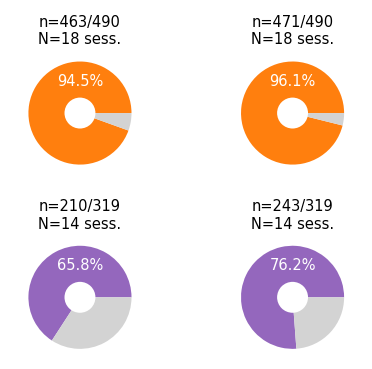

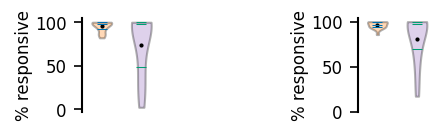

In [4]:
from scipy import stats

SUMMARY = np.load('../data/in-vivo/summary-episodes.npy', allow_pickle=True).item()

fig1, AX1 = pt.figure(axes=(2,2),figsize=(1.,1.2))

cases, colors = ['WT', 'KO'], ['tab:orange', 'tab:purple']

for i, case in enumerate(cases):
    for c, contrast in enumerate([0.5, 1.0]):
        resp = np.sum([np.sum(r) for r in SUMMARY[case]['SIGNIFICANT_c=%.1f' % contrast]])
        tot = np.sum([len(r) for r in SUMMARY[case]['SIGNIFICANT_c=%.1f' % contrast]])
        pt.pie([100*resp/tot, 100*(1-resp/tot)], ax=AX1[i][c], COLORS=[colors[i], 'lightgrey'])
        pt.annotate(AX1[i][c], '%.1f%%' % (100*resp/tot), (.5,.85), va='top', ha='center',color='w', fontsize=7)
        AX1[i][c].set_title('n=%i/%i\nN=%i sess.' % (resp,tot,len(SUMMARY[case]['SIGNIFICANT_c=%.1f' % contrast])), fontsize=7)

fig2, AX2 = pt.figure(axes=(2,1), figsize=(.6,1.), wspace=5.)
for c, contrast in enumerate([0.5, 1.0]):
    for i, case in enumerate(cases):
        frac = 100*np.mean([r for r in SUMMARY[case]['FRAC_RESP_c=%.1f' % contrast]])
        pt.violin(100*np.array(SUMMARY[case]['FRAC_RESP_c=%.1f' % contrast]),
                  X=[i], COLORS=[colors[i]], ax=AX2[c])
    pt.set_plot(AX2[c], ['left'], ylabel='% responsive', yticks=[0,50,100])
stats.mannwhitneyu(SUMMARY['WT']['FRAC_RESP_c=1.0'], SUMMARY['KO']['FRAC_RESP_c=1.0'])

fig1.savefig('../figures/in-vivo/summary-responsiveness.svg')
fig1.savefig('../figures/Figure5/summary-responsiveness.pdf')

In [5]:
def build_resp(SUMMARY, key, contrast, average_by='sessions'):
    
    if average_by=='sessions':
        resp = np.array([np.mean(r, axis=0) for r in SUMMARY[key]['RESPONSES_c=%.1f' % contrast]])
    else:
        resp = np.concatenate([r for r in SUMMARY[key]['RESPONSES_c=%.1f' % contrast]])
        
    resp = np.clip(resp, 0, np.inf) # CLIP RESPONSIVE TO POSITIVE VALUES

    return resp

# Temporal Dynamics of Visually-Evoked Responses

In [6]:
TAU_DECONVOLUTION = 1.5

dFoF_parameters['smoothing'] = 1.5

def compute_summary_responses(DATASET,
                              Nmax=999, # max datafiles (for debugging)
                              stat_test_props=dict(interval_pre=[-1.,0],                                   
                                                   interval_post=[1.,2.],                                   
                                                   test='anova',                                            
                                                   positive=True),
                              response_significance_threshold=5e-2,
                              verbose=True):
    
    SUMMARY = np.load('../data/in-vivo/summary-episodes.npy', allow_pickle=True).item()

    SUMMARY['dFoF_args'] = dFoF_parameters
    
    for key in ['WT', 'KO']:
        SUMMARY[key]['subjects'] = []
        SUMMARY[key]['tstart'] = []
        SUMMARY[key]['tstop'] = []
        
        for contrast in [0.5, 1]:
            SUMMARY[key]['WAVEFORMS_c=%.1f' % contrast] = []
            
        for f, s, significant in zip(DATASET[key]['files'][:Nmax],
                                     DATASET[key]['subjects'],
                                     SUMMARY[key]['SIGNIFICANT_c=1.0']):
            
            SUMMARY[key]['subjects'].append(s)
            print('analyzing "%s" [...] ' % f)
            data = Data(f, verbose=False)
            
            data.build_dFoF(**dFoF_parameters, verbose=False)
            data.build_Deconvolved(Tau=TAU_DECONVOLUTION)
            data.init_visual_stim()

            protocol = 'ff-gratings-8orientation-2contrasts-15repeats' if\
                        ('ff-gratings-8orientation-2contrasts-15repeats' in data.protocols) else\
                        'ff-gratings-8orientation-2contrasts-10repeats'

            for contrast in [0.5, 1]:
                
                t, significant_waveforms = compute_tuning_response_per_cells(data,
                                                                             prestim_duration=2.5,
                                                                             imaging_quantity='Deconvolved',
                                                                             contrast=contrast,
                                                                             protocol_name=protocol,
                                                                             stat_test_props=stat_test_props,
                                                                             response_significance_threshold=\
                                                                                          response_significance_threshold,
                                                                             verbose=False,
                                                                             return_significant_waveforms=True)
                
                SUMMARY[key]['WAVEFORMS_c=%.1f' % contrast].append(significant_waveforms)
                
    SUMMARY['t'] = t
    print('done ! ')
    
    return SUMMARY

SUMMARY = compute_summary_responses(DATASET,
                                    verbose=False)
np.save('../data/in-vivo/summary-deconvolved.npy', SUMMARY)

analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-01/sub-01_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-01/sub-01_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 


/Users/yann/miniconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-02/sub-02_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-02/sub-02_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-03/sub-03_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-03/sub-03_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-04/sub-04_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-04/sub-04_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-05/sub-05_ses-01_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild-Type/sub-05/sub-05_ses-02_V1-ffGratingStim-2Prec.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-ffGratingStim-2P/Wild

In [7]:
from scipy.optimize import minimize

def gaussian(t, X):
    return (1-X[1])*np.exp(-t**2/2/X[0]**2)+X[1]
                 
def fit_gaussian_width(shift, array,
                       min_time=0.1,
                       max_time=2.5):
    def func(X):
        return np.sum(np.abs(gaussian(shift, X)-array/np.max(array)))
    res = minimize(func, [3*min_time,0,1],
                   bounds=[[min_time, max_time],
                           [-max_time, max_time],
                           [0,1]], method='L-BFGS-B')
    return res.x

KO 0.74 +/- 0.18 ms
WT 1.56 +/- 0.19 ms


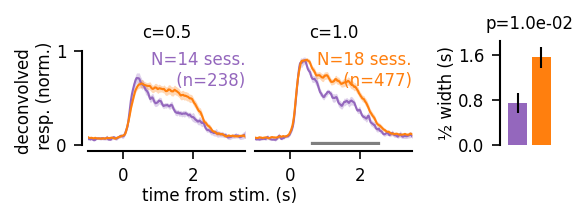

In [8]:
SUMMARY = np.load('../data/in-vivo/summary-deconvolved.npy', allow_pickle=True).item()

fig, AX = pt.figure(axes=(2,1),figsize=(1.1,1.),wspace=0.1, right=7.)

cases, colors = ['KO', 'WT'], ['tab:purple', 'tab:orange']

inset = pt.inset(AX[1], [1.6,0.,0.3,1.1])

fitInterval = [0.7, 2.5]
Widths = {}
for i, case in enumerate(cases):
    Widths[case] = []
    c1 = [np.mean(r, axis=0) for r in SUMMARY[case]['WAVEFORMS_c=1.0']]
    for c, contrast in enumerate([0.5, 1.0]):

        resp = [np.mean(r, axis=0) for r in SUMMARY[case]['WAVEFORMS_c=%.1f' % contrast]]
        #resp = np.divide(resp, np.max(resp, axis=1, keepdims=True))
        resp = np.divide(resp, np.max(c1, axis=1, keepdims=True))
        
        pt.plot(SUMMARY['t'], np.mean(resp, axis=0),#/np.mean(responsive_CCs, axis=0).max(),
                sy=stats.sem(resp, axis=0),
                #sy=np.std(resp, axis=0),
                color=colors[i], ax=AX[c])
        if c:
            pt.annotate(AX[i],'N=%i sess.\n (n=%i)' % (\
                            len(SUMMARY[case]['WAVEFORMS_c=%.1f' % contrast]),
                            np.sum([len(r) for r in SUMMARY[case]['WAVEFORMS_c=%.1f' % contrast]])),
                        (1,1), va='top', ha='right', color=colors[i])
    # fit here, i.e. at full contrast
    cond = (SUMMARY['t']>fitInterval[0]) & (SUMMARY['t']<fitInterval[1]) 
    for iSession in range(len(resp)):
        Widths[case].append(fit_gaussian_width(SUMMARY['t'][cond]-fitInterval[0],
                            resp[iSession][cond]/np.max(resp[iSession]
                                                        [cond]))[0])
    print(case, '%.2f +/- %.2f ms' % (np.mean(Widths[case]), stats.sem(Widths[case])))
    inset.bar([i], [np.mean(Widths[case])], yerr=[stats.sem(Widths[case])], color=colors[i])

AX[1].plot(fitInterval, [0,0], 'k-', lw=3, alpha=0.5)

pt.set_plot(inset, ['left'], 
            title='p=%.1e' % stats.mannwhitneyu(Widths['WT'], Widths['KO']).pvalue,
            ylabel=u'\u00bd' + ' width (s)')

for c, contrast in enumerate([0.5, 1.0]):
    pt.set_plot(AX[c], ['left','bottom'] if c==0 else ['bottom'],
                xlim=[-1,3.5], yticks=[0,1], xticks=[0,2],
                yticks_labels=['0','1'] if c==0 else [],
                ylim=[0,1], 
                ylabel='deconvolved \n resp. (norm.)' if c==0 else '',
                title='c=%.1f' % contrast,
                xlabel=20*' '+'time from stim. (s)' if c==0 else '')
fig.savefig('../figures/in-vivo/summary-evoked-resp.svg')
fig.savefig('../figures/Figure5/summary-evoked-resp.pdf')